# Intro

## Data can be found here: https://www.statnett.no/for-aktorer-i-kraftbransjen/tall-og-data-fra-kraftsystemet/last-ned-grunndata/

This project aims to use years of data from the power industry, in Norway, to predict Consumption per hour. The motivation for this is that it may help stakeholders to know how much they should produce in terms of power and reduce under/over producing.

# 0.0 Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

import xgboost as xgb
import optuna
import shap

import glob
import os
import pickle
import joblib
from datetime import datetime

# 1. Data ingestion

## The files from Statnett has the extension xls, but in reality they are html files. One way is to simply open each file and save them as xlsx and import them. I wanted to automate the process so I chose to convert all the files and append them into one big xlsx file called output.xlsx

In [2]:
folder_path = '../Data/Raw Data'  
all_files = glob.glob(os.path.join(folder_path, '*.xls'))

dataframes = []

for file in all_files:
    try:
        tables = pd.read_html(file, flavor='lxml')
        for df in tables:
            # If first row is header again, drop it
            if list(df.columns) != ['Time(Local)', 'Production', 'Consumption']:
                df.columns = df.iloc[0]  # Set proper column names
                df = df.drop(df.index[0])  # Drop header row from data
            dataframes.append(df)
    except Exception as e:
        print(f"Failed to read {file}: {e}")

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Parse datetime (with day-first and timezone awareness)
combined_df['Time(Local)'] = pd.to_datetime(combined_df['Time(Local)'], dayfirst=True, utc=True)

# Remove timezone 
combined_df['Time(Local)'] = combined_df['Time(Local)'].dt.tz_localize(None)

combined_df = combined_df.rename(columns={'Time(Local)': 'DateTime'})

# Export to Excel 
combined_df.to_excel('../Data/Processed Data/output.xlsx', index=False)

In [3]:
combined_df

,DateTime,Production,Consumption
0,2011-12-31 23:00:00,15223,15493
1,2012-01-01 00:00:00,13650,15332
2,2012-01-01 01:00:00,12858,15098
3,2012-01-01 02:00:00,12555,14840
4,2012-01-01 03:00:00,12096,14591
...,...,...,...
119010,2025-07-29 17:00:00,16096,12888
119011,2025-07-29 18:00:00,16036,12856
119012,2025-07-29 19:00:00,16043,12683
119013,2025-07-29 20:00:00,16501,12704


In [4]:
combined_df.dtypes

0
DateTime       datetime64[ns]
Production             object
Consumption            object
dtype: object

In [5]:
combined_df['Production'] = pd.to_numeric(combined_df['Production'], errors='coerce')
combined_df['Consumption'] = pd.to_numeric(combined_df['Consumption'], errors='coerce')

In [6]:
combined_df.dtypes

0
DateTime       datetime64[ns]
Production              int64
Consumption             int64
dtype: object

# 2. EDA

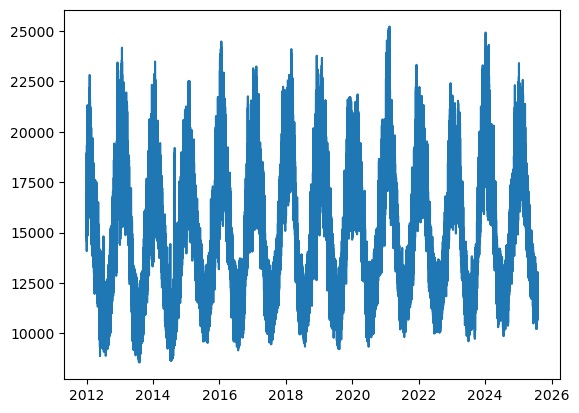

In [7]:
plt.plot(combined_df['DateTime'],combined_df['Consumption'])

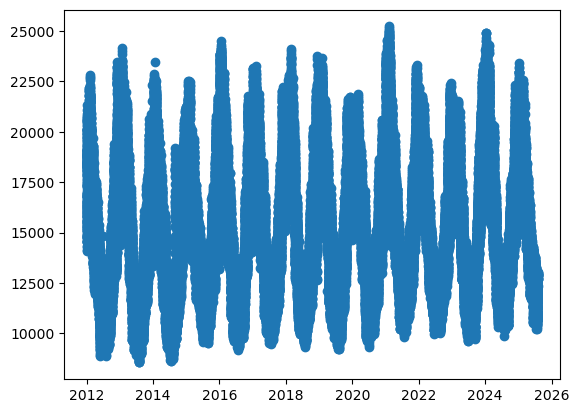

In [8]:
plt.scatter(combined_df['DateTime'],combined_df['Consumption'])

### The data is clearly cyclical, which makes sense. Let's explore shorter timescales.

### 2.1 EDA for timespan of one year

In [9]:
start_date = '2012-01-01'
end_date = '2012-12-30'

mask = (combined_df['DateTime'] >= start_date) & (combined_df['DateTime'] < end_date)
year = combined_df.loc[mask]

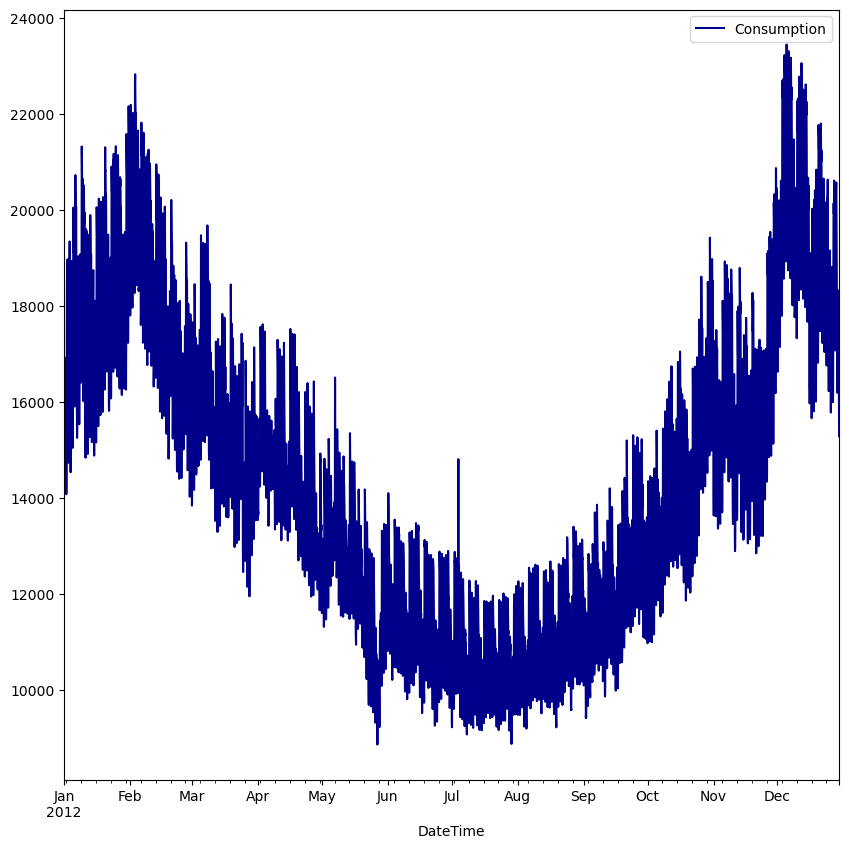

In [10]:
year_plot = year.plot(x='DateTime', y='Consumption', c='DarkBlue', figsize=(10,10))

### We can see that the highest consumption is during Dec, Jan, Feb. the lowest during the summer months (in Norway), which most likely is due to vacation times and less demand for power to heat households and industrial facilities

### 2.2 Let us see for 1 month (Jan)

In [11]:
start_date = '2012-01-01'
end_date = '2012-01-31'

mask = (combined_df['DateTime'] >= start_date) & (combined_df['DateTime'] < end_date)
month = combined_df.loc[mask]

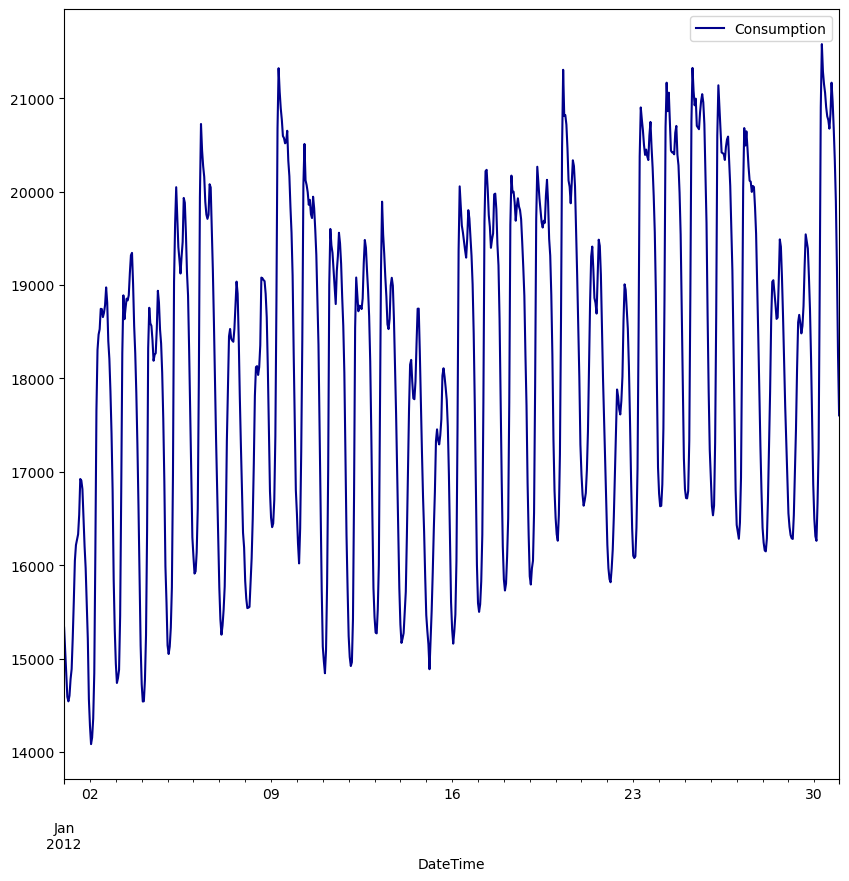

In [12]:
month_plot = month.plot(x='DateTime', y='Consumption', c='DarkBlue', figsize=(10,10))

### 2.3 One month (July)

In [13]:
start_date = '2012-07-01'
end_date = '2012-07-31'

mask = (combined_df['DateTime'] >= start_date) & (combined_df['DateTime'] < end_date)
month = combined_df.loc[mask]

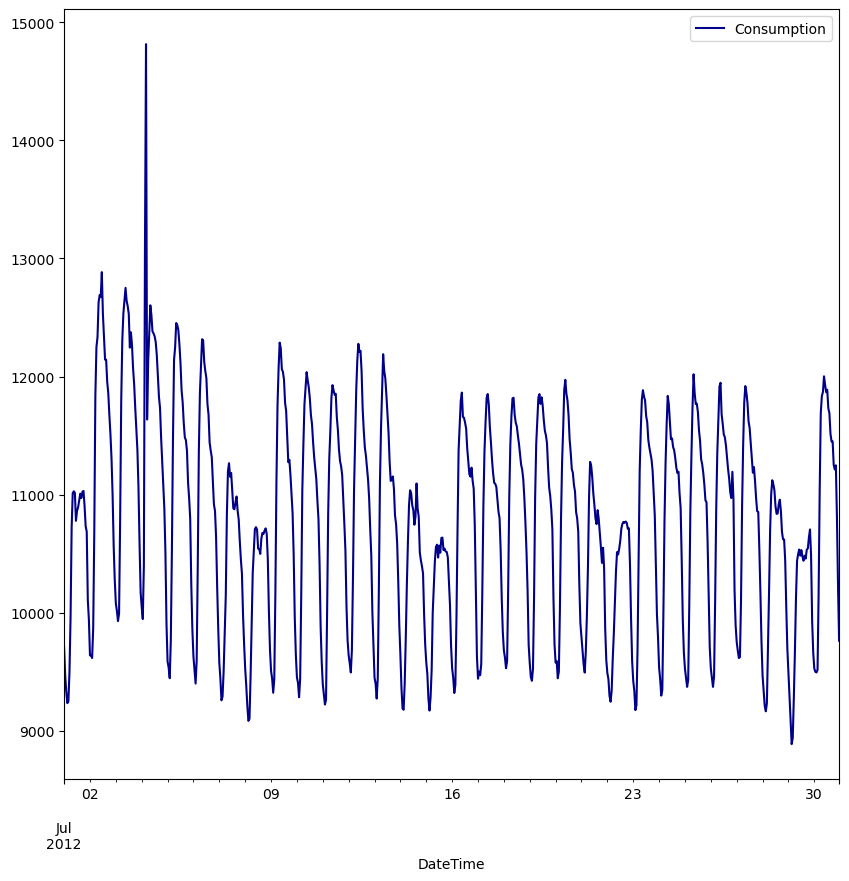

In [14]:
month_plot = month.plot(x='DateTime', y='Consumption', c='DarkBlue', figsize=(10,10))

### 2.4 Let's check for one week

In [15]:
start_date = '2012-07-02'
end_date = '2012-07-09'

mask = (combined_df['DateTime'] >= start_date) & (combined_df['DateTime'] < end_date)
week = combined_df.loc[mask]

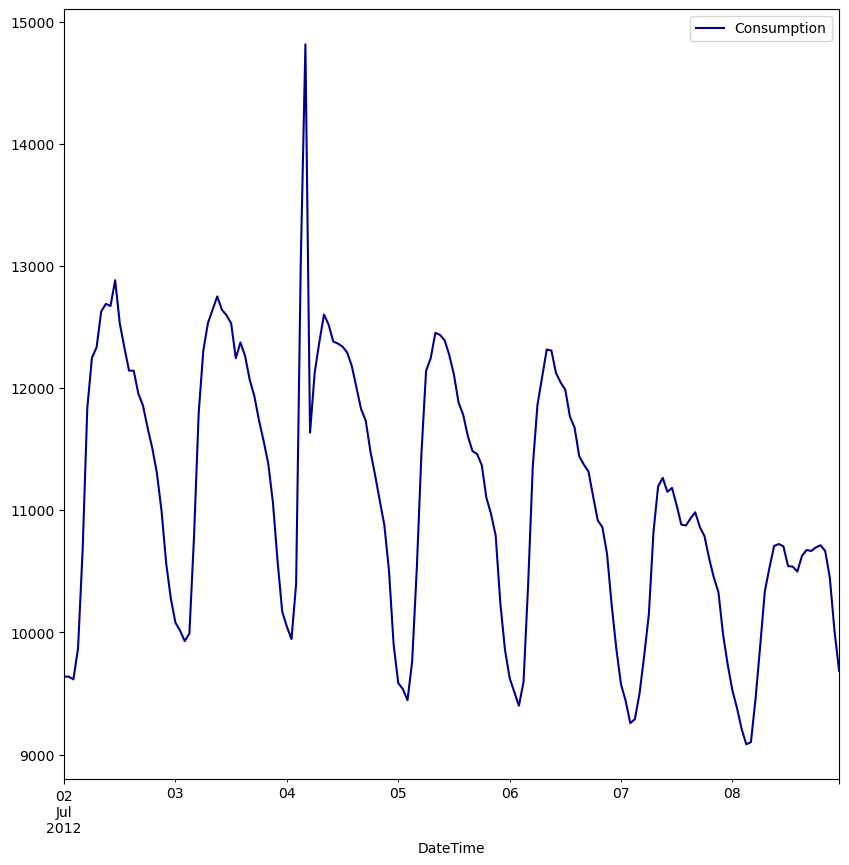

In [16]:
week_plot = week.plot(x='DateTime', y='Consumption', c='DarkBlue', figsize=(10,10))

### July 2nd 2012 Was a monday, we can see that the highest consumption is Mon-Fri, which makes sense since they are workdays and industries are in need of power. Interestingly there is a huge spike on July fourth, clearly an outlier for the period.  

### 2.5 Check week cycle for a winter week

In [17]:
start_date = '2012-12-10'
end_date = '2012-12-17'

mask = (combined_df['DateTime'] >= start_date) & (combined_df['DateTime'] < end_date)
week = combined_df.loc[mask]

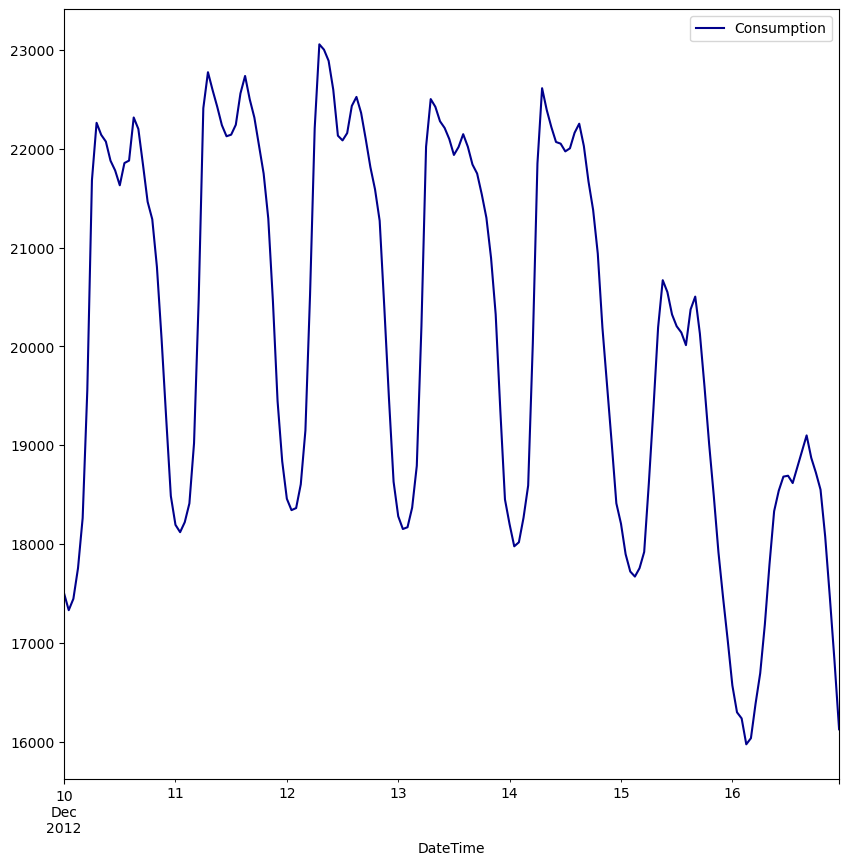

In [18]:
week_plot = week.plot(x='DateTime', y='Consumption', c='DarkBlue', figsize=(10,10))

# 3. Feature Creation

In [ ]:
combined_df['Hour'] = combined_df['DateTime'].dt.hour
combined_df['Day'] = combined_df['DateTime'].dt.day
combined_df['Month'] = combined_df['DateTime'].dt.month
combined_df['Year'] = combined_df['DateTime'].dt.year

In [ ]:
# Mean consumption per hour and day
grouped_by_day = combined_df.groupby('Day').mean()
grouped_by_day['Day'] = grouped_by_day.index
grouped_by_hour = combined_df.groupby('Hour').mean()
grouped_by_hour['Hour'] = grouped_by_hour.index

### 3.1 Hourly graphs

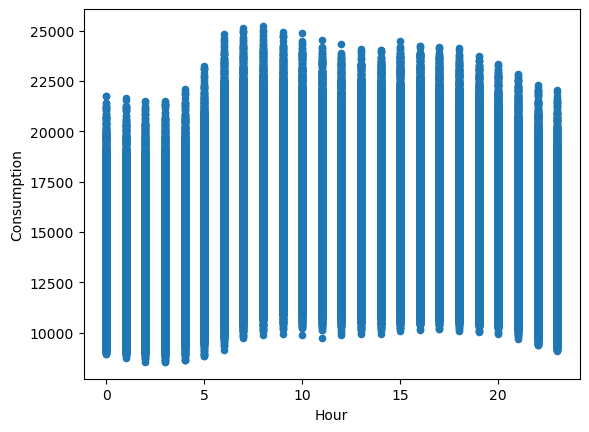

In [21]:
hourly = combined_df.plot.scatter(x='Hour',y='Consumption')

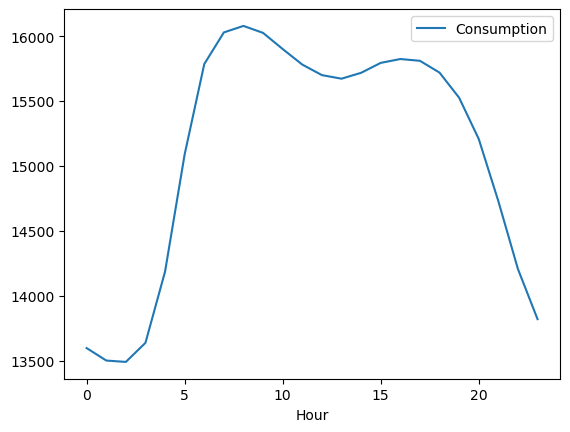

In [22]:
hourly_grouped = grouped_by_hour.plot(x='Hour',y='Consumption')

### 3.2 Weekly graphs

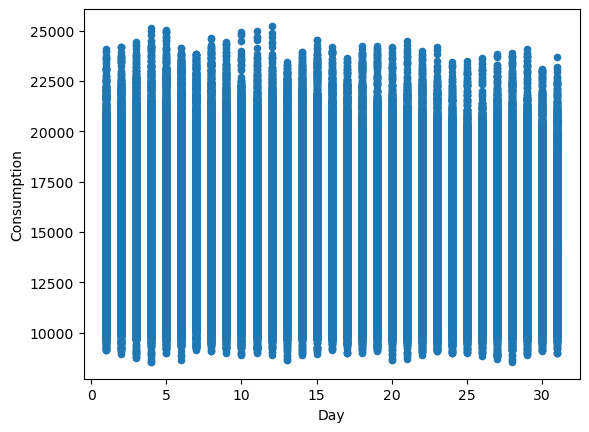

In [23]:
weekly = combined_df.plot.scatter(x='Day',y='Consumption')

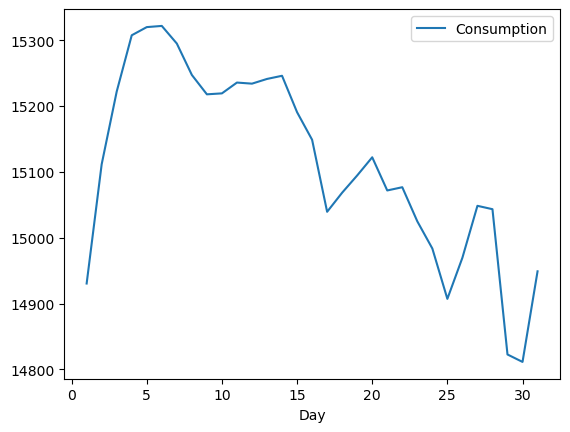

In [24]:
weekly_grouped = grouped_by_day.plot(x='Day',y='Consumption')

## 3.3 check correlation between variables

In [25]:
combined_df

,DateTime,Production,Consumption,Hour,Day,Month,Year
0,2011-12-31 23:00:00,15223,15493,23,31,12,2011
1,2012-01-01 00:00:00,13650,15332,0,1,1,2012
2,2012-01-01 01:00:00,12858,15098,1,1,1,2012
3,2012-01-01 02:00:00,12555,14840,2,1,1,2012
4,2012-01-01 03:00:00,12096,14591,3,1,1,2012
...,...,...,...,...,...,...,...
119010,2025-07-29 17:00:00,16096,12888,17,29,7,2025
119011,2025-07-29 18:00:00,16036,12856,18,29,7,2025
119012,2025-07-29 19:00:00,16043,12683,19,29,7,2025
119013,2025-07-29 20:00:00,16501,12704,20,29,7,2025


In [26]:
corr_df = combined_df[['Production','Consumption','Hour','Day','Month','Year']]

In [27]:
corr_matrix = corr_df.corr()

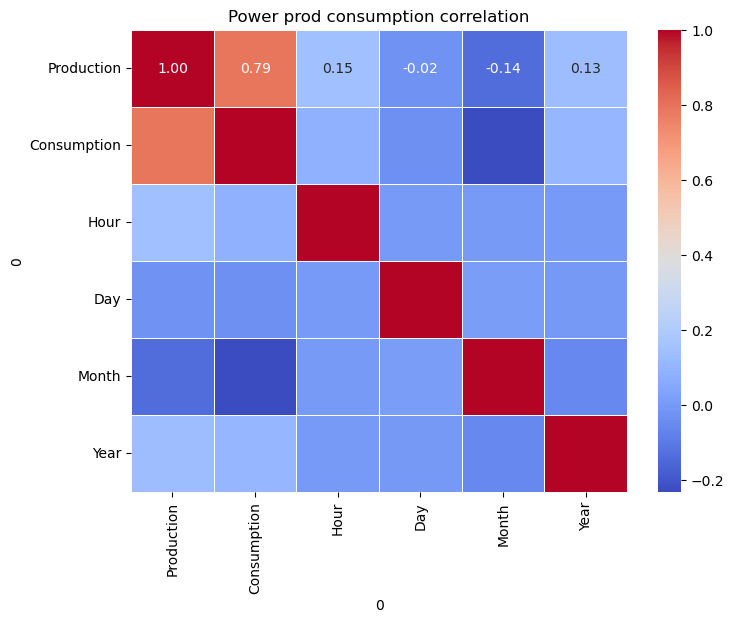

In [28]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",linewidths=0.5)
plt.title("Power prod consumption correlation")
plt.show()

# 4.0 RF Regressor

In [101]:
# Use sort values for good practice, even though dataset was alreeady sorted
combined_df = combined_df.sort_values(["Year","Month","Day","Hour"])

train_size = int(len(combined_df) * 0.75)

train = combined_df.iloc[:train_size]
test  = combined_df.iloc[train_size:]

X_train = train[['Year','Month','Day','Hour']]
y_train = train['Consumption']

X_test = test[['Year','Month','Day','Hour']]
y_test = test['Consumption']

In [102]:
# This scaler is not necessary for RF
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [103]:
random_forest_one = RandomForestRegressor().fit(X_train,y_train)

In [104]:
random_forest_score = format(random_forest_one.score(X_test,y_test))
print('Random Forest R Squared: ',random_forest_score)

Random Forest R Squared:  0.7938769401999882


In [105]:
# Check for overfitting
print(random_forest_one.score(X_train, y_train))

0.9986723869635651


In [106]:
# Predict
y_pred_rf_one = random_forest_one.predict(X_test)

# Evaluate
rf_one_mse = mean_squared_error(y_test, y_pred_rf_one)
rf_one_r2 = r2_score(y_test, y_pred_rf_one)
rf_one_rmse = np.sqrt(rf_one_mse)

print(f"Mean Squared Error: {rf_one_mse:.2f}")
print(f"R^2 Score: {rf_one_r2:.2f}")
print(f"Random Forest One RMSE: {rf_one_rmse:.2f}")

Mean Squared Error: 1962492.71
R^2 Score: 0.79
Random Forest One RMSE: 1400.89


In [113]:
new_data = [
    [2025, 4, 13, 11],
    [2025, 8, 15, 11],
    [2025,12,1, 11],
    [2025,16,2, 11],
    [2025,20,3, 11],
    [2025,0,4, 11],
    [2025,4,5, 11],
    [2025,8,6, 11],
    [2025,12,7, 11],
    [2025,16,8, 11],
    [2025,20,9, 11],
    [2025,22,10, 11]
]

prediction_list_rf = random_forest_one.predict(new_data)
prediction_list_xgb_show = prediction_list_rf.tolist()
prediction_list_xgb_show

c:\Users\jonat\anaconda3\envs\env4\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[17627.83,
 12447.57,
 21975.03,
 21951.05,
 22434.55,
 20412.22,
 17192.93,
 12740.26,
 22703.2,
 21995.75,
 21457.72,
 20783.8]

## 5.0 XGBoost model

In [107]:
# Initialize and train the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=4, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)

print(f"Mean Squared Error: {xgb_mse:.2f}")
print(f"R^2 Score: {xgb_r2:.2f}")
print(f"XGBoost One RMSE: {xgb_rmse:.2f}")


Mean Squared Error: 1483770.51
R^2 Score: 0.84
XGBoost One RMSE: 1218.10


## Slightly better values with XGBoost so  we will go with this one.

In [111]:
# List of predictions
new_data = [
    [2025, 4, 13, 11],
    [2025, 8, 15, 11],
    [2025,12,1, 11],
    [2025,16,2, 11],
    [2025,20,3, 11],
    [2025,0,4, 11],
    [2025,4,5, 11],
    [2025,8,6, 11],
    [2025,12,7, 11],
    [2025,16,8, 11],
    [2025,20,9, 11],
    [2025,22,10, 11]
]

prediction_list_xgb = xgb_model.predict(new_data)
prediction_list_xgb_show = prediction_list_xgb.tolist()

In [112]:
prediction_list_xgb_show

[15318.6689453125,
 12046.6376953125,
 19953.80859375,
 19981.83203125,
 20005.0234375,
 19985.0078125,
 15742.5009765625,
 11966.078125,
 19972.703125,
 19987.888671875,
 19750.138671875,
 19495.564453125]

In [133]:
# Save model
with open("xgb_model.pkl","wb") as f:
    pickle.dump(xgb_model,f)